In [1]:
import sklearn
import nltk

from generateWordFrequency import *
from naiveBayes import *
from fileWriteFunctions import *

In [2]:
AllClasses = ['story', 'ask_hn', 'show_hn', 'poll']
delta = 0.5
appendClassPrefix = 'prob_'

In [3]:
unfilteredTrainData = getDataframe(2018)
unfilteredTrainData = addTokenizedColumnofTitle(unfilteredTrainData)

In [4]:
unfilteredTestData = getDataframe(2019)
unfilteredTestData = addTokenizedColumnofTitle(unfilteredTestData)
unfilteredTestData = unfilteredTestData.reset_index()

In [5]:
accuracies = []
VocabularySize = []
for percent in [5,10,15,20,25]:

    trainWords = getWordFrequencyDataframe(unfilteredTrainData,AllClasses)
    filteredWordList = getWordListBasedOnPercent(trainWords,Percent = percent)
    
    trainData = filterTokensByWordList(unfilteredTrainData.copy(),filteredWordList)
    trainWords = getWordFrequencyDataframe(trainData,AllClasses)
    priorProbabilities = getPriorProbabilities(trainData)    
    
    trainWords = getWordFrequencyDataframe(trainData,AllClasses)
    trainWords = obtainDataframeWithClassProbabilities(trainWords, AllClasses, delta, appendClassPrefix)
    trainWords = renameModelRows(trainWords, AllClasses, appendClassPrefix)
    model = [trainWords, priorProbabilities]
    
    testData = filterTokensByWordList(unfilteredTestData.copy(),filteredWordList)
    
    testData = generateCondClassProb(testData, model)
    testData['predicted'] = generatePrediction(testData,AllClasses)
    testResults = comparePredictions(testData,AllClasses)
    check = testResults.comparision.value_counts()
    accuracy = check[True]/(check[True]+check[False])
    
    accuracies.append(accuracy)
    VocabularySize.append(len(trainWords.columns))
    print(percent,accuracy,len(trainWords.columns))

5 0.9245053383376453 87993
10 0.924629231498014 83362
15 0.9245417775024597 78731
20 0.9244834748387567 74100
25 0.9244980505046825 69468


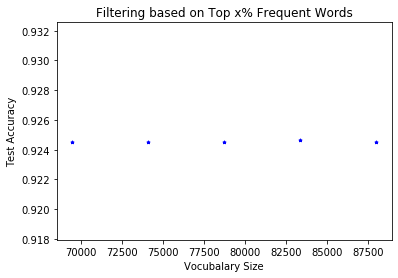

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.scatter(VocabularySize, accuracies, marker='*',
           s=10, facecolor='blue')
plt.xlabel('Vocubalary Size')
plt.ylabel('Test Accuracy')
plt.title('Filtering based on Top x% Frequent Words')
plt.show()